#  Demo file: RI confidence intervals

This notebook demonstrates our approach to finding RI-based p-values and Fisher confidence intervals for sharp, additive treatment effects. 

Three programs are involved, and their use is documented here:
1. `ri_estimates` conducts RI and returns $p$-values;
2. `impute_tx` allows the user to specify the DGP and add or subtract a given, hypothesized treatment effect.
3. `ri_ci` uses the above functions to calculate RI confidence intervals.

In [1]:
%show_gui

In [2]:
//  Some preliminaries for stata
clear all
set seed 12345
set matsize 11000
set scheme s1mono

//  Add /ado/ subdirectory to top of Stata's search path.
//  Assume we are EITHER in the root of the github repo OR in the /demo/ folder to begin.
if regexm("`c(pwd)'","demo") local pwd = subinstr(subinstr("`c(pwd)'","\","/",.),"/demo", "", 1)
else local pwd "`c(pwd)'"
di as err "The current working directory is `pwd'"
adopath ++`pwd'/ado 








The current working directory is D:/GitHub/RI_CI

  [1]              "D:/GitHub/RI_CI/ado"
  [2]  (BASE)      "C:\Program Files (x86)\Stata15\ado\base/"
  [3]  (SITE)      "C:\Program Files (x86)\Stata15\ado\site/"
  [4]              "."
  [5]  (PERSONAL)  "c:\ado\personal/"
  [6]  (PLUS)      "c:\ado\plus/"
  [7]  (OLDPLACE)  "c:\ado/"
  [8]              "C:\Programs\Anaconda3\Lib\site-packages\stata_kernel\ado"


In [3]:
// Force reload of Stata programs
capture program drop ri_estimates
capture program drop impose_tx 

##  Simulate some data

Let's generate 500 observations according to the genrative model
\begin{align}
y_0 &= e_0 \\
y_1 &= y_0 + \tau
\end{align}

with $\tau = 1$ and $e_0\sim N(0,1)$

In [4]:
set obs 500
global tau = 1
ge y0 = rnormal()
ge y1 = y0 + $tau


number of observations (_N) was 0, now 500





Let treatment assignment be by simple randomization. We need to do two things:

1. create a set of $R$ feasible randomizations, to feed into the RI machine and to feed into the DGP for observed outcomes; and 
2. generate observed outcome $y$ according to the switching regression 
    \begin{equation}
    y = y_0 + t(y_1 - y_0)
    \end{equation}

In [5]:
global R = 500 //  number of randomizations to consider.

In [6]:
ge t_0 = (runiform() >= 0.5)
ge y = y0 + t_0*(y1-y0)

In [7]:
ge i = _n // an identifier for observations, used later to merge potential treatments
tempfile T0 
preserve 
keep i t_0
forvalues r=1/$R {
    ge t_`r' = (runiform() >= 0.5 )
}
save `T0'
restore 







file C:\Users\az332\AppData\Local\Temp\ST_38d0_000001.tmp saved



##  Estimate and get a p-value

In [8]:
capture program drop ri_estimates
ri_estimates, permutations($R) t1(t , filename(`T0') key(i)) teststat(t) pointestimates pvalues : regress y t
mat li r(RESULTS)
global tstat = el(r(RESULTS),rownumb(r(RESULTS),"t"),colnumb(r(RESULTS),"t"))
global pval  = el(r(RESULTS),rownumb(r(RESULTS),"t"),colnumb(r(RESULTS),"p"))
mat T0 = r(T0)
di "The t statistic is $tstat, with p-value $pval"



Point estimates, analytical SEs

      Source |       SS           df       MS      Number of obs   =       500
-------------+----------------------------------   F(1, 498)       =     73.16
       Model |  78.9447515         1  78.9447515   Prob > F        =    0.0000
    Residual |  537.343109       498  1.07900223   R-squared       =    0.1281
-------------+----------------------------------   Adj R-squared   =    0.1263
       Total |   616.28786       499  1.23504581   Root MSE        =    1.0388

------------------------------------------------------------------------------
           y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           t |   .7947317   .0929116     8.55   0.000     .6121846    .9772788
       _cons |   .1559891   .0654351     2.38   0.018     .0274262     .284552
------------------------------------------------------------------------------
file C:\Users\az




number of observations will be reset to 500
Press any key to continue, or Break to abort
number of observations (_N) was 0, now 500


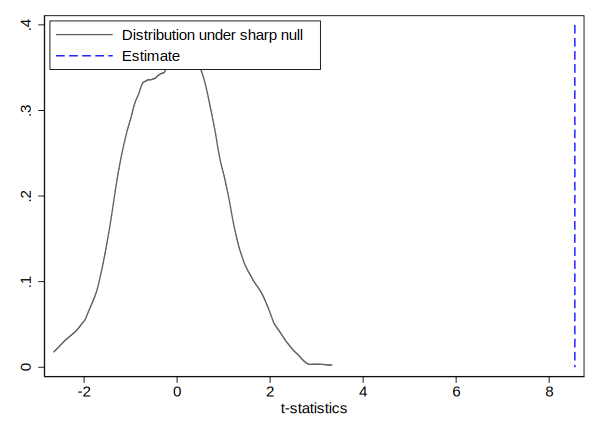

In [9]:
// Visualizing result
preserve
drop _all 
svmat T0, names(tstat)
twoway (kdensity tstat) ///
    (scatteri 0.4 $tstat 0 $tstat, recast(line) lcolor(blue) lpattern(dash)) ///
    , /// xline($tstat, lcolor(blue))  ///
    xtitle("t-statistics") /// xscale(range($tstat)) /// 
    legend(order(1 "Distribution under sharp null" 2 "Estimate") cols(1) position(11) ring(0))
restore

## Calculate CI

##  The first thing we need is a language to describe the dgp and (add or) subtract a treatment effect.

The command `impose_tx` does so, allowing us to describe the dgp using [Wilkinson-Rogers Notation](http://www.jerous.org/att/2016/05/11/wilkinson-rogers/wilkinson2formula.html).  Use the `subtract` option to take away the specified treatment effect from those treated (`treatment==1`); otherwise, default behavior will be to add it.  Specify a new variable (in the example below, `yprime`) to hold the generated variable.

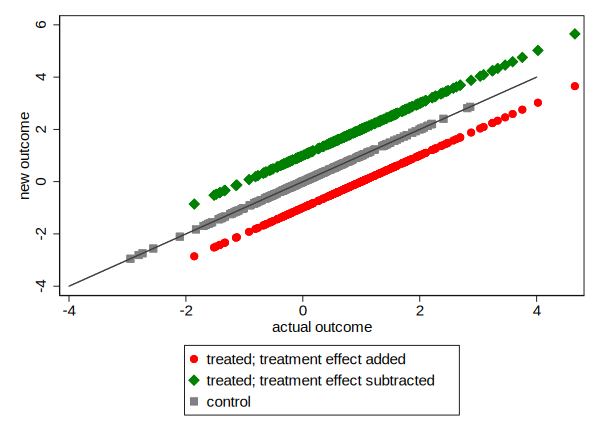

In [10]:
capture program drop impose_tx
capture drop yminus
capture drop yplus

//  Example where treatment effect is being subtracted
qui ge yminus = .
impose_tx , dgp(y ~ t_0) treatment(1) y(yminus) subtract

//  Example where treatment effect is being added
qui ge yplus = .
impose_tx, dgp(y ~ t_0) treatment(1) y(yplus)

tw (sc yminus y if t_0 == 1, mcolor(red)) ///
    (sc yplus y if t_0 == 1, mcolor(green)) ///
    (sc yminus y if t_0 == 0) ///
    (function y=x , range(-4 4)) /// (line y y, sort) ///
    , legend(order(1 "treated; treatment effect added" 2 "treated; treatment effect subtracted" 3 "control") cols(1)) ///
    ytitle("new outcome") xtitle("actual outcome")

## The second thing we need is the ability to conduct RI for non-sharp nulls.

This requires the ability to specify the data-generating process---which should be distinct from the estimator that delivers the test statistic---for randomization inference, in `ri_estimates()`.

In [11]:
capture program drop ri_estimates
ri_estimates, permutations($R) t1(t , filename(`T0') key(i))  dgp(y ~ t) treatmenteffect(1) /// imposing the *true* DGP
    teststat(t) pvalues values($tstat) /// using previously estimated t-statistic to compute a p-value for this sharp null.
    : regress y t
mat li r(RESULTS) // show p-value 
mat T0alt = r(T0)  // capture distribution of test statistic under sharp null.



file C:\Users\az332\AppData\Local\Temp\ST_38d0_000005.tmp saved
RI: Permutation of T1...
... done.
number of observations (_N) was 0, now 0


symmetric r(RESULTS)[1,1]
      p
t  .124



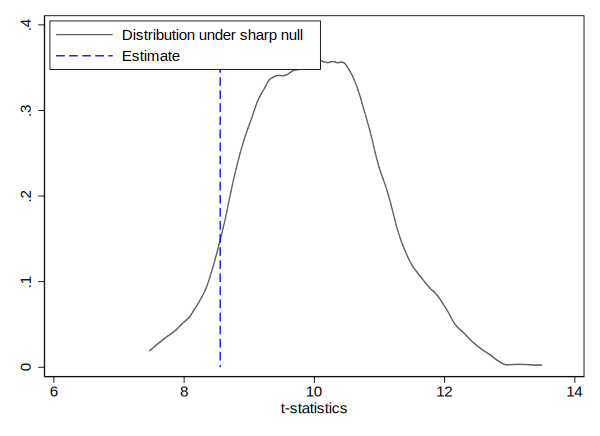

In [12]:
// Visualizing result
preserve
drop _all 
qui svmat T0alt, names(tstat)
twoway (kdensity tstat) ///
    (scatteri 0.4 $tstat 0 $tstat, recast(line) lcolor(blue) lpattern(dash)) ///
    , /// xline($tstat, lcolor(blue))  ///
    xtitle("t-statistics") /// xscale(range($tstat)) /// 
    legend(order(1 "Distribution under sharp null" 2 "Estimate") cols(1) position(11) ring(0))
restore

##  The third thing we need is a search process to arrive at an estimated 95% CI.

This involves a few key decisions, which will be programmed in the wrapper function `ri_ci`, which uses `impute_tx` and `ri_estimates` as defined above.

**Choose starting values**.  Looking ahead to the possibility of test statistics that are not based on regression, but (for now) assuming the DGP is always  a linear model, one possibility would be to use the analytical standard errors on a linear regression that corresponds to the DGP as a starting point.  

-  One option is just to let the user specify a starting value (actually, one for each endpoint).  Let's program this option first, since it seems easiest. 
-  When the test statistic is derived from a linear model, can use analytical SE
-  When the DGP is specified as a linear model, can estimate it via OLS and then use analytical SE.

**Define a stopping rule**.  How should the stopping rule be defined?  
- Fixed number of trial values (safe starting point)
- (User-specified) step distance;
- Something else?

In [15]:
//  demo the ri_ci command.
ri_ci, numtrials(10) permutations($R) ///
    t1(t, filename(`T0') key(i) ) ///
    teststat(t) ///
    dgp(y ~ t ) ///
    ci0( 10 -10) ///
    : reg y t // estimation command delivering the test statistic.


The suggested starting interval runs from lb -10 to ub 10

      Source |       SS           df       MS      Number of obs   =       500
-------------+----------------------------------   F(1, 498)       =     73.16
       Model |  78.9447515         1  78.9447515   Prob > F        =    0.0000
    Residual |  537.343109       498  1.07900223   R-squared       =    0.1281
-------------+----------------------------------   Adj R-squared   =    0.1263
       Total |   616.28786       499  1.23504581   Root MSE        =    1.0388

------------------------------------------------------------------------------
           y |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
           t |   .7947317   .0929116     8.55   0.000     .6121846    .9772788
       _cons |   .1559891   .0654351     2.38   0.018     .0274262     .284552
-----------------------------------------------------------------------


Trial results in search for upper bound:


TRIALS_UB[10,3]
            tau0  permutations        pvalue
r1            10           500             0
r1             5           500             0
r1           2.5           500          .748
r1          3.75           500          .004
r1         3.125           500          .152
r1        3.4375           500           .08
r1       3.59375           500          .028
r1      3.671875           500          .016
r1     3.6328125           500           .02
r1     3.6132813           500           .02

Trial results in search for lower bound:


TRIALS_LB[10,3]
            tau0  permutations        pvalue
r1           -10           500             0
r1            -5           500             0
r1          -2.5           500          .004
r1         -1.25           500           .36
r1        -1.875           500           .08
r1       -2.1875           500           .02
r1      -2.03125           500          .048
r1     -2.109375         

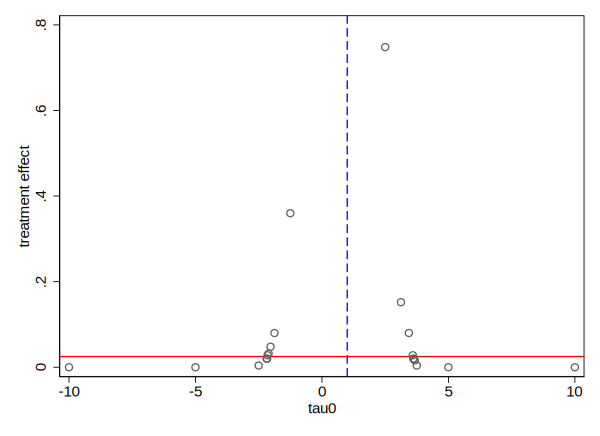

In [16]:
//  Visualize results
di "Trial results in search for upper bound:"
mat li TRIALS_UB
di "Trial results in search for lower bound:"
mat li TRIALS_LB 

preserve
clear 
tempfile trials 
svmat TRIALS_UB, names(col)
save `trials' 

clear 
svmat TRIALS_LB, names(col)
append using `trials'

tw sc pvalue tau0 [w=permutations] ///
    , msymbol(oh) ///
    yline(0.025, lcolor(red)) ytitle("p-values") ///
    xline(1, lcolor(blue) lpattern(dash)) ytitle("treatment effect")
restore 